<a href="https://colab.research.google.com/github/Vurimindi2021/Capstone3/blob/main/src/translated/nlp_contradictory_bert_ml_cased_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install dask[Bag]

In [ ]:
import os, datetime, math
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import callbacks
from transformers import BertTokenizer, TFBertModel
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from dask import bag, diagnostics
import tensorflow as tf
import tensorflow_hub as hub
import transformers
from contextlib import nullcontext

In [ ]:
chkpt_path = "/content/drive/MyDrive/nlp/check_point/bert_ml_cased.h5"
log_path = os.path.join("/content/drive/MyDrive/nlp/logs/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/nlp/data/translated/english_transled_train.csv")
test = pd.read_csv("/content/drive/MyDrive/nlp/data/translated/english_transled_test.csv")
print(train.iloc[18344])
train.drop(18344, axis=0, inplace=True)

id                                                  t4d82105a36
premise                                                     NaN
hypothesis    La ligne considérée introduit l'œuvre à laquel...
lang_abv                                                     fr
language                                                 french
label                                                         0
Name: 18344, dtype: object


In [ ]:
batch_size  = 16                           # Batch Size
epochs      = 10                           # Number of Epochs in model.fit
train_size  = 23738                        # Number of Obs in Training Dataset
val_size    = 5195                         # Number of Obs in Validation Dataset
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))
steps_per_epoch = compute_steps_per_epoch(train_size)
val_steps = compute_steps_per_epoch(val_size)

In [ ]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
MAX_LENGTH=80
max_len=MAX_LENGTH*2

In [ ]:
def encode_sentence(s):
   return tokenizer.encode(s,padding='max_length', max_length=MAX_LENGTH,truncation=True)

In [ ]:
def bert_encode(hypotheses, premises, tokenizer):
    
  #num_examples = len(hypotheses)
  
  sentence1 = tf.ragged.constant([encode_sentence(s) for s in np.array(hypotheses)])
  sentence2 = tf.ragged.constant([encode_sentence(s) for s in np.array(premises)])

  #cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  #type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)

In [ ]:
test_input  = bert_encode(test.premise.values, test.hypothesis.values, tokenizer)

In [ ]:
def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,),dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,),dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,),dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

In [ ]:
with strategy.scope():
  model = build_model()
  model.summary()

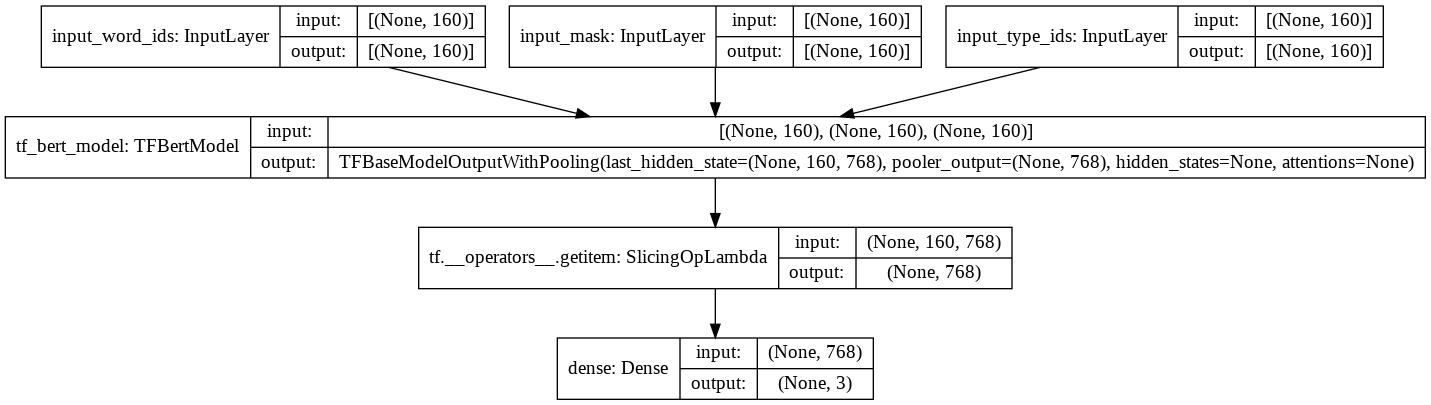

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file='/content/drive/MyDrive/nlp/figs/translated/bert_ml_case.png')

In [ ]:
# saving model at best accuracy epoch
checkpoint = callbacks.ModelCheckpoint(filepath=chkpt_path,
                                    save_weights_only=True,
                                    monitor="val_sparse_categorical_accuracy",
                                    mode='max',
                                    verbose = 0,
                                    save_best_only=True,
                                    save_freq = "epoch")
earlystop = callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy", 
                                    min_delta=0.001, 
                                    patience=5, 
                                    verbose=1,
                                    mode='auto', 
                                    baseline=None, 
                                    restore_best_weights=False)

In [ ]:
history=model.fit(x=train_input, 
                  y=train.label.values, 
                  epochs=epochs,
                  verbose = 1, 
                  validation_split = 0.2,
                  batch_size=batch_size,
                  callbacks =[checkpoint])

Epoch 1/10


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 160) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 160) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 160) dtype=int32>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=int64>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 160) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 160) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 160) dtype=int32>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=int64>]


1187/1187 [==============================] - ETA: 0s - loss: 0.9277 - accuracy: 0.5508

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 160) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 160) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 160) dtype=int32>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=int64>]


1187/1187 [==============================] - 184s 93ms/step - loss: 0.9277 - accuracy: 0.5508 - val_loss: 0.8839 - val_accuracy: 0.5842


Epoch 2/10
1187/1187 [==============================] - 102s 86ms/step - loss: 0.7056 - accuracy: 0.6971 - val_loss: 0.8409 - val_accuracy: 0.6295


Epoch 3/10
1187/1187 [==============================] - 102s 86ms/step - loss: 0.4966 - accuracy: 0.8021 - val_loss: 1.0481 - val_accuracy: 0.6148


Epoch 4/10
1187/1187 [==============================] - 102s 86ms/step - loss: 0.3028 - accuracy: 0.8859 - val_loss: 1.1172 - val_accuracy: 0.6394


Epoch 5/10
1187/1187 [==============================] - 102s 86ms/step - loss: 0.1851 - accuracy: 0.9320 - val_loss: 1.4441 - val_accuracy: 0.6302


Epoch 6/10
1187/1187 [==============================] - 102s 86ms/step - loss: 0.1279 - accuracy: 0.9545 - val_loss: 1.4148 - val_accuracy: 0.6481


Epoch 7/10
1187/1187 [==============================] - 102s 86ms/step - loss: 0.0919 - accuracy: 0.9672 - val_loss: 1.6625 - val_accuracy: 0.6396


Epoch 8/10
1187/1187 [==============================] - 102s 86ms/step - loss: 0.0746 - accuracy: 0.9726 - val_loss: 1.6414 - val_accuracy: 0.6439


Epoch 9/10
1187/1187 [==============================] - 102s 86ms/step - loss: 0.0643 - accuracy: 0.9771 - val_loss: 1.8455 - val_accuracy: 0.6363


Epoch 10/10
1187/1187 [==============================] - 102s 86ms/step - loss: 0.0516 - accuracy: 0.9821 - val_loss: 1.8680 - val_accuracy: 0.6468


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


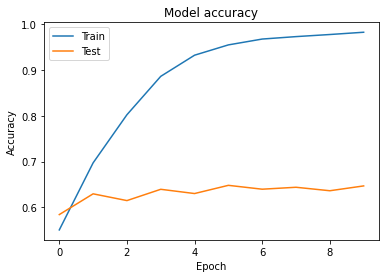

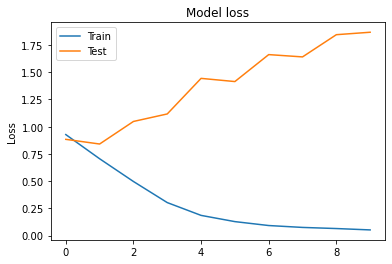

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(fname='/content/drive/MyDrive/figs/translated/bert_ml_cased_model_accuracy.png')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(fname='/content/drive/MyDrive/figs/translated/bert_ml_cased_model_loss.png')
plt.show()


In [ ]:
predictions = [np.argmax(i) for i in model.predict(test_input)]

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 160) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 160) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 160) dtype=int32>]


In [ ]:
submission = test.id.copy().to_frame()
submission['prediction'] = predictions
submission.head()
submission.to_csv("/content/drive/MyDrive/nlp/data/translated/bert_ml_cased.csv", index = False)